# Partners in Wine

<img src="wine.png" width="400" height="500">

## What is the dataset?
This dataset is various attributes describing the chemical makeup of the wine Portuguese "Vinho Verde" wine. for varying seasons.  

fixed acidity;volatile acidity;citric acid;residual sugar;chlorides;free sulfur dioxide;total sulfur dioxide;density;pH;sulphates;alcohol;quality

## What will we do with this dataset?
Perform some stuff to discover stuff about the data. First we need to read the file with all the data.




In [2]:
import utils

table = utils.read_table('red_wine_quality.csv')
header = table[0]
table = table[1:]

## K-Means Clustering 

We can use k-means clustering to determine what attributes make for a high quality wine. K-means clustering groups up instances that are closest to eachother with k groups. This image is an example:

<img src="cluster.png" width="400" height="500">

The code below is used to find the best k for our dataset. We are going to try k=3 to k=10. We will plot the objective function scores in order to find the "elbow" point, the point at which the total sum of squares drops less drastically. 

3
20109.461284475514
4
17532.757186276147
5
15022.907290461892
6
13449.400493270117
7
12606.124901529858
8
12006.615679687857
9
11418.718938499796
10
11074.03223631212


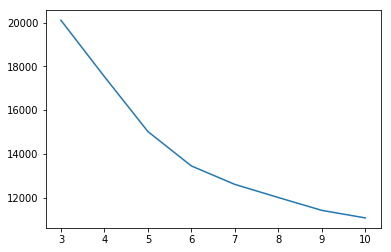

In [27]:
import random
import math
import copy
import numpy
import matplotlib.pyplot as plt
import k_means

def k_means_clustering(k, table):
    # Select k objects in an arbitrary fashion. Use these as the initial set of k centroids.
    centroids = k_means.select_init_centroids(k, table)
    
    match = False
    while match == False: 
        
        # Compute the distances of each instance to each centroid
        distances_table = [ [] for i in range(len(table)) ]
        for centroid in centroids:
            k_means.append_distance(table, distances_table, centroid)

        # Find the biggest distance and assign instance to that centroid
        k_means.find_centroid(distances_table)

        # Recalculate the centroids by getting the mean of each cluster
        new_centroids = k_means.recalculate_centroids(table, distances_table, [])

        # Check to see if the centroids have converged
        match = k_means.compare_centroids(centroids, new_centroids)
        centroids = new_centroids

    # Now we know what instance belongs to what cluster
    # table and distances are "parallel tables" 
    score = objective_function(table, distances_table, centroids)
    return score, distances_table, centroids
    
def objective_function(table, cluster_table, centroids):
    # Combine and group by cluster 
    new_table = combine_tables(table, cluster_table)
    cluster_index = len(new_table[0])-1
    group_names, groups = utils.group_by(new_table, cluster_index)
    
    # for each cluster, compute the sum of squares
    # add these to a cluster_total of all clusters
    total_cluster_score = 0
    for i, cluster in enumerate(groups):
        distances = []
        for row in cluster:
            distance = compute_distance(row, centroids[row[cluster_index]])
            distances.append(distance)
        total_cluster_score += sum(distances)
    print(total_cluster_score)
    return total_cluster_score
        
def find_best_cluster(table, minimum, maximum):
    objective_scores = []
    x_axis = []
    for i in range(minimum, maximum+1):
        print(i)
        score, cluster_table, centroids = k_means_clustering(i, table)
        objective_scores.append(score)
        x_axis.append(i)
    
    plt.figure()
    plt.plot(x_axis, objective_scores)
    plt.show()

# find the best k for clustering from 3-10.
find_best_cluster(table, 3, 10)

## Best K is 6! 

Each time this runs, the values change a little bit but it is roughly the same output everytime. The elbow point appears to be around 6 or 7 everytime. We will choose to use 6 clusters. 

Now that we have found the best number of clusters, we can use them to learn more information about our dataset. We can also predict unseen instances. We do this by finding what cluster the unseen instance belongs to and then doing majority voting on that cluster to classify the instance's quality rating. 

First, we will look at the cluster and see what we can find out by observing the averages of each attribute for each cluster. 

In [37]:
# cluster the dataset to form 6 groups 
score, distances_table, centroids = k_means_clustering(6, table)

# create a cluster table
cluster_table = copy.deepcopy(table)
for i, row in enumerate(cluster_table):
    cluster_table[i].append(distances_table[i][-1])

# group by cluster 
group_names, groups = utils.group_by(cluster_table, len(cluster_table[0])-1)

# for each cluster, let's find out some stuff.
for i, group in enumerate(groups):
    values, counts = utils.get_frequencies(group, header.index("quality"))
    avg_att_vals = compute_average(group, len(group[0])-1)
    print("=" * 60)
    print("Cluster " + str(i+1) + ":")
    print("=" * 60)
    
    # get the most frequently occuring quality classification
    most_freq_qual_index = counts.index(max(counts))
    most_freq_quality = values[most_freq_qual_index]
    print("Most Frequent Classification: ", most_freq_quality)
    print()
    
    # print the average for each attribute
    print("Averages for Each Attribute ")
    for i, attribute in enumerate(avg_att_vals):
        print(header[i] + ": ", attribute)
    
    print("=" * 60)
    print()
    




13449.400493270117
Cluster 1:
Most Frequent Classification:  5.0

Averages for Each Attribute 
fixed acidity:  8.15
volatile acidity:  0.52
citric acid:  0.28
residual sugar:  2.48
chlorides:  0.09
free sulfur dioxide:  25.55
total sulfur dioxide:  65.09
density:  1.0
pH:  3.33
sulphates:  0.68
alcohol:  10.27
quality:  5.55

Cluster 2:
Most Frequent Classification:  5.0

Averages for Each Attribute 
fixed acidity:  8.06
volatile acidity:  0.56
citric acid:  0.32
residual sugar:  3.45
chlorides:  0.09
free sulfur dioxide:  32.28
total sulfur dioxide:  139.06
density:  1.0
pH:  3.23
sulphates:  0.7
alcohol:  9.8
quality:  5.13

Cluster 3:
Most Frequent Classification:  5.0

Averages for Each Attribute 
fixed acidity:  7.8
volatile acidity:  0.58
citric acid:  0.26
residual sugar:  3.1
chlorides:  0.09
free sulfur dioxide:  23.2
total sulfur dioxide:  95.5
density:  1.0
pH:  3.31
sulphates:  0.64
alcohol:  10.09
quality:  5.39

Cluster 4:
Most Frequent Classification:  6.0

Averages for 

## What can we take away? 

By observing the averages for each attribute in each cluster, we have discovered some attributes that vary. We noticed that the clusters with the most classifications of a quality 6 have some attributes that vary from clusters that are mostly a 5 rating. 

6 rating has:
slightly higher fixed acidity
a lower residual sugar
a lower free sulfur dioxide
a lower total sulfur dioxide

We can inform the vineyard of this information and to carefully monitor these properties because it appears to have an affect on the quality.



# Making Predictions with clusters

### Holdout, Stratify, etc. Compare to other classifiers so get the accuracies

In [39]:
def majority_voting(cluster, classification_index):
    # get the frequency of the classfication index
    values, counts = utils.get_frequencies(cluster, classification_index)
    
    # get the biggest one 
    highest_freq_index = counts.index(max(counts))
    
    # return that classification
    return values[highest_freq_index]
    
def predict(random_instance, centroids, clusters, classification_index):
    distances = []
    for centroid in centroids:
        distance = compute_distance(random_instance, centroid)
        distances.append(distance)
    cluster_index = distances.index(min(distances))
    
    majority_classification = majority_voting(clusters[cluster_index], classification_index)
    print("Random Instance: ", random_instance)
    print("Majority Classification: ", majority_classification)

# predicting
random_instance = [8.9,0.22,0.48,1.8,0.077,29,60,0.9968,3.39,0.53,9.4,6]
predict(random_instance, centroids, groups, header.index("quality"))

Random Instance:  [8.9, 0.22, 0.48, 1.8, 0.077, 29, 60, 0.9968, 3.39, 0.53, 9.4, 6]
Majority Classification:  5.0
